In [172]:
import pandas as pd

meta_data = 'prokaryotes.csv'
filter_data = 'genome_list.csv'

meta_data = pd.read_csv(meta_data)
filter_data = pd.read_csv(filter_data, header=None)


split_data = meta_data['RefSeq FTP'].str.split('/', expand=True)
last_column = split_data.iloc[:, -1]

META = pd.concat([meta_data, last_column], axis=1)
META.rename(columns={META.columns[-1]: 'genome_ID'}, inplace=True)


overlap = filter_data.isin(last_column)

biosample_ID = []
last_column_values = META.iloc[:, -1] # Get the values in the last column of META
last_column_values_list = last_column_values.tolist()

total = 0
for item in filter_data[0]:
    if item in last_column_values_list:
        index = last_column_values_list.index(item)
        biosample_ID_each = META.iloc[index, 3]
        biosample_ID.append(biosample_ID_each)
len(biosample_ID)

2069

In [174]:
META
ID_map= META.set_index('BioSample')['genome_ID'].to_dict()
ID_map

{'SAMN11579495': 'GCF_013393845.1_ASM1339384v1',
 'SAMN08774111': 'GCF_003119375.1_ASM311937v1',
 'SAMN08744595': 'GCF_003076895.1_ASM307689v1',
 'SAMN13706869': 'GCF_028609665.1_ASM2860966v1',
 'SAMN06042545': 'GCF_002220985.3_HGAP',
 'SAMN18394829': 'GCF_019321785.1_ASM1932178v1',
 'SAMN06061934': 'GCF_001996365.2_ASM199636v2',
 'SAMN08851398': 'GCF_003047085.1_ASM304708v1',
 'SAMN32136210': 'GCF_030064615.1_ASM3006461v1',
 'SAMN17188276': 'GCF_021729985.1_ASM2172998v1',
 'SAMN16252928': 'GCF_025920025.1_ASM2592002v1',
 'SAMN10436686': 'GCF_009883835.1_ASM988383v1',
 'SAMN32966975': 'GCF_028551295.1_ASM2855129v1',
 'SAMN12648285': 'GCF_009763565.1_ASM976356v1',
 'SAMN35083686': 'GCF_030059845.1_ASM3005984v1',
 'SAMN03325855': 'GCF_001700835.1_ASM170083v1',
 'SAMN32136211': 'GCF_030064635.1_ASM3006463v1',
 'SAMN07629020': 'GCF_003612695.1_ASM361269v1',
 'SAMN12648283': 'GCF_009763605.1_ASM976360v1',
 'SAMN06310878': 'GCF_003085735.1_ASM308573v1',
 'SAMN28511831': 'GCF_025917745.1_ASM2

In [165]:
filter_data

,0
0,GCF_000154045.1_ASM15404v1
1,GCF_000182345.1_ASM18234v1
2,GCF_000182365.1_ASM18236v1
3,GCF_000182385.1_ASM18238v1
4,GCF_000182465.1_ASM18246v1
...,...
2064,GCF_948193475.1_VP161965
2065,GCF_948193485.1_VP180961
2066,GCF_948193725.1_VP960010
2067,GCF_948193765.1_VP910015


In [126]:
import requests
from bs4 import BeautifulSoup

def fetch_biosample_data_non_SAMEA(biosample_id):
    isolation_source = 'isolation_source_NA'
    host_source = 'host_source_NA'
    description_source = 'description_source_NA'
    
    efetch_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=biosample&id={biosample_id}"
    print(efetch_url)
    response = requests.get(efetch_url)
    soup = BeautifulSoup(response.text, 'lxml')  # Use 'lxml' parser for XML

    # Check for attributes containing the word "isolation"
    isolation_tags = soup.find_all('attribute', 
                                   attribute_name=lambda x: x and 'isolation' in x.lower())
    if isolation_tags:
        # Just take the first tag for simplicity, you can adjust as needed
        isolation_source = isolation_tags[0].text

    # For host_source
    host_tags = soup.find_all('attribute', 
                              attribute_name=lambda x: x and 'host' in x.lower())
    if host_tags:
        host_source = host_tags[0].text

    # For description_source
    description_source = soup.find('description').find('title').text if soup.find('description') and soup.find('description').find('title') else 'description_source_NA'
    print(f"BioSample ID: {biosample_id}, \nIsolation Source: {isolation_source}, Host Source: {host_source}, Description Source: {description_source}")

    return isolation_source, host_source, description_source


def fetch_biosample_data_SAMEA(biosample_id):
    BASE_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    isolation_source = 'isolation_source_NA'
    host_source = 'host_source_NA'
    description_source = 'description_source_NA'

    # Use esearch to get the internal ID for the BioSample ID
    esearch_url = f"{BASE_URL}esearch.fcgi?db=biosample&term={biosample_id}&retmode=json"
    print(esearch_url)
    try:
        esearch_response = requests.get(esearch_url).json()
        id_list = esearch_response.get('esearchresult', {}).get('idlist', [])

        if not id_list:
            print("No results found for this BioSample ID.")
            return isolation_source, host_source, description_source

        # Use efetch to retrieve the full record for the internal ID
        efetch_url = f"{BASE_URL}efetch.fcgi?db=biosample&id={id_list[0]}&retmode=xml"
        print(efetch_url)
        response = requests.get(efetch_url)
        soup = BeautifulSoup(response.text, 'lxml')  # Use 'lxml' parser for XML

        # Check for attributes containing the word "isolation"
        isolation_tags = soup.find_all('attribute', 
                                       attribute_name=lambda x: x and 'isolation' in x.lower())
        if isolation_tags:
            # Just take the first tag for simplicity, you can adjust as needed
            isolation_source = isolation_tags[0].text

        # Check for attributes containing the word "host"
        host_tags = soup.find_all('attribute', 
                                  attribute_name=lambda x: x and 'host' in x.lower())
        if host_tags:
            host_source = host_tags[0].text

        # For description_source
        description_tag = soup.find('description')
        if description_tag and description_tag.find('title'):
            description_source = description_tag.find('title').text
        print(f"BioSample ID: {biosample_id}, \nIsolation Source: {isolation_source}, Host Source: {host_source}, Description Source: {description_source}")
        return isolation_source, host_source, description_source

    except Exception as e:
        print(f"An error occurred: {e}")
        return isolation_source, host_source, description_source
    
# Test
biosample_id = 'SAMN10426773'
isolation_source, host_source, description_source = fetch_biosample_data_SAMEA(biosample_id)



https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=biosample&term=SAMN10426773&retmode=json
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=biosample&id=11350621&retmode=xml
BioSample ID: SAMN10426773, 
Isolation Source: mixed culture fermentation bioreactor, Host Source: host_source_NA, Description Source: Mineral fed SBR taken at 10 SRT


In [87]:
def label_catcher(biosample_ID):
    source_list = []
    host_list = []
    description_list = []
    for ID in biosample_ID:
        isolation_source, host_source, description_source = fetch_biosample_data_SAMEA(ID)
        source_list.append(isolation_source)
        host_list.append(host_source)
        description_list.append(description_source)
    return source_list, host_list, description_list

source_list, host_list, description_list = label_catcher(biosample_ID)



BioSample ID: SAMN02435886, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus AQ3810
BioSample ID: SAMN02436220, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus Peru-466
BioSample ID: SAMN02436312, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus AQ4037
BioSample ID: SAMN02436265, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus AN-5034
BioSample ID: SAMN02436183, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus K5030
BioSample ID: SAMN02952920, 
Isolation Source: missing, Host Source: Homo sapiens, Description Source: Pathogen: clinical or host-associated sample from Vibri

In [95]:
unique_isolation = list(set(source_list))
# Convert unique values to pandas DataFrame
isolation = pd.DataFrame(unique_isolation, columns=["Isolation"])
# Export DataFrame to CSV
isolation.to_csv("unique_isolation.csv", index=False)

In [88]:
def label_catcher_xml(biosample_ID):
    source_list = []
    host_list = []
    description_list = []
    for ID in biosample_ID:
        isolation_source, host_source, description_source = fetch_biosample_data_non_SAMEA(ID)
        source_list.append(isolation_source)
        host_list.append(host_source)
        description_list.append(description_source)
    return source_list, host_list, description_list

source_list_nonSAMEA, host_list_nonSAMEA, description_list_nonSAMEA = label_catcher(biosample_ID)


BioSample ID: SAMN02435886, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus AQ3810
BioSample ID: SAMN02436220, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus Peru-466
BioSample ID: SAMN02436312, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus AQ4037
BioSample ID: SAMN02436265, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus AN-5034
BioSample ID: SAMN02436183, 
Isolation Source: isolation_source_NA, Host Source: host_source_NA, Description Source: Generic sample from Vibrio parahaemolyticus K5030
BioSample ID: SAMN02952920, 
Isolation Source: missing, Host Source: Homo sapiens, Description Source: Pathogen: clinical or host-associated sample from Vibri

In [187]:
data = {
    'Biosample_ID': biosample_ID,
    'Isolation_Source': source_list,
    'Host_Source': host_list,
    'Description_Source': description_list
}

df = pd.DataFrame(data)
df.loc[:, 'Label'] = pd.NA
list(set(df['Isolation_Source']))

['Oyster',
 'raw shrimp',
 'Clam',
 'clinical isolate',
 'Stewed meat',
 'food',
 'Aquatic bird feces',
 'human gut',
 'shell fish',
 'sediment',
 'seafood (corb shell)',
 'water sample',
 'hepatopancreas',
 'Macerated stomach and hepatopancreas samples from shrimp. Samples were grown in TCBS and colonies purified on TSA plates according to morphology. Isolate was cultured in TCBS.',
 'laboratory sample',
 'environment gulf coast',
 'Mollusk',
 'clinic',
 'marine',
 'seawater',
 'Crab Marinated in Soy Sauce',
 'seawater layers',
 'stomach',
 'imported seafood from Thailand',
 'shrimp',
 'Shellfish',
 'marine water',
 'Imported/domestic retail Mussels',
 'sea-bass',
 'clinical',
 'AHPND infected pond water',
 'Rectal Swab',
 'feces',
 'Spiced duck',
 'Mussel',
 'aquaculture pond',
 'Aquaculture environmental',
 'anal swab',
 'Atlantic coast',
 'human with diarrhea assosiated with seafood cunsumption, Hospital General',
 'Missing',
 'seafood',
 'cutting board',
 'visceral',
 'oyster samp

In [151]:
df_1stRoundLabel = pd.read_csv('1stLabel.csv')
df_1stRoundLabel['isolation_Source']


0                                    isolation_source_NA
1                                                 oyster
2                                                  stool
3                   Stomach of Penaeus vannamei juvenile
4                                                missing
                             ...                        
136    Macerated stomach and hepatopancreas samples f...
137                                                 pork
138                                           shell fish
139                  not available: to be reported later
140                mixed culture fermentation bioreactor
Name: isolation_Source, Length: 141, dtype: object

In [152]:
dict_result = df_1stRoundLabel.set_index('isolation_Source')['Label'].to_dict()
dict_result

{'isolation_source_NA': nan,
 'oyster': 'Non_clinical',
 'stool': 'Clinical',
 'Stomach of Penaeus vannamei juvenile': 'Non_clinical',
 'missing': nan,
 'environment': 'Non_clinical',
 'environment gulf coast': 'Non_clinical',
 'stomach': nan,
 'sediment': 'Non_clinical',
 'EMS/AHPND-diseased hepatopancreas': 'Non_clinical',
 'shrimp pond': 'Non_clinical',
 'shrimp pond sediment': 'Non_clinical',
 'oyster sample': 'Non_clinical',
 'water sample': 'Non_clinical',
 'stool sample': 'Clinical',
 'plankton sample': 'Non_clinical',
 'clinical sample': 'Clinical',
 'not collected': nan,
 'unknown': nan,
 'not applicable': nan,
 'clinical patient': 'Clinical',
 'oysters': 'Non_clinical',
 'environmental': 'Non_clinical',
 'Mollusc': 'Non_clinical',
 'seafood': 'Non_clinical',
 'Canada': nan,
 'Mollusk': 'Non_clinical',
 'Clam': 'Non_clinical',
 'Oyster': 'Non_clinical',
 'Imported Shrimp': 'Non_clinical',
 'littoral Pacific Ocean Southern Chile': 'Non_clinical',
 'human with diarrhea assosiate

## 1st round label

In [153]:
df['Label'] = df['Isolation_Source'].map(dict_result)
df

,Biosample_ID,Isolation_Source,Host_Source,Description_Source,Label
0,SAMN02435886,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus AQ...,NaN
1,SAMN02436220,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus Pe...,NaN
2,SAMN02436312,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus AQ...,NaN
3,SAMN02436265,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus AN...,NaN
4,SAMN02436183,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus K5030,NaN
...,...,...,...,...,...
2064,SAMEA112324435,human,host_source_NA,BGISP-100 sequencing of VP161965,Clinical
2065,SAMEA112324441,isolation_source_NA,host_source_NA,BGISP-100 sequencing of VP180961,NaN
2066,SAMEA112324446,human,host_source_NA,BGISP-100 sequencing of VP960010,Clinical
2067,SAMEA112324445,human,host_source_NA,BGISP-100 sequencing of VP910015,Clinical


In [154]:
df_2ndRoundLabel = pd.read_csv('2ndLabel.csv')
df_2ndRoundLabel

,Host_Source,Label
0,host_source_NA,NaN
1,Homo sapiens,Clinical
2,missing,NaN
3,penaeid shrimp,Non_clinical
4,Penaeus vannamei,Non_clinical
5,not applicable,NaN
6,finespotted flounder,Non_clinical
7,oysters,Non_clinical
8,toothfish,Non_clinical
9,Shrimps,Non_clinical


## Round 2 label creation

In [155]:
dict_result_2nd = df_2ndRoundLabel.set_index('Host_Source')['Label'].to_dict()
dict_result_2nd

{'host_source_NA': nan,
 'Homo sapiens': 'Clinical',
 'missing': nan,
 'penaeid shrimp': 'Non_clinical',
 'Penaeus vannamei': 'Non_clinical',
 'not applicable': nan,
 'finespotted flounder': 'Non_clinical',
 'oysters': 'Non_clinical',
 'toothfish': 'Non_clinical',
 'Shrimps': 'Non_clinical',
 'Mytilus edulis': 'Non_clinical',
 'Missing': nan,
 'clam': 'Non_clinical',
 'Penaeus sp.': 'Non_clinical',
 'Mussels': 'Non_clinical',
 'mussel': 'Non_clinical',
 'Mollusc': 'Non_clinical',
 'Ostreidae': 'Non_clinical',
 'Homos sapiens': 'Clinical',
 'fish': 'Non_clinical',
 'shrimp': 'Non_clinical',
 'Penaeus monodon': 'Non_clinical',
 'Seawater': 'Non_clinical',
 'scallop': 'Non_clinical',
 'Oyster': 'Non_clinical',
 'Penaeus vannamei (Whiteleg shrimp)': 'Non_clinical',
 'Holothuria leucospilota': 'Non_clinical',
 'Ctenopharyngodon idella': 'Non_clinical',
 'Paratapes undulatus': 'Non_clinical',
 'Perna viridis': 'Non_clinical',
 'Hypophthalmichthys nobilis': 'Non_clinical',
 'Mactra quadrangul

In [156]:
mask = df['Label'].isna()
df.loc[mask, 'Label'] = df.loc[mask, 'Host_Source'].map(dict_result_2nd)
df


,Biosample_ID,Isolation_Source,Host_Source,Description_Source,Label
0,SAMN02435886,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus AQ...,NaN
1,SAMN02436220,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus Pe...,NaN
2,SAMN02436312,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus AQ...,NaN
3,SAMN02436265,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus AN...,NaN
4,SAMN02436183,isolation_source_NA,host_source_NA,Generic sample from Vibrio parahaemolyticus K5030,NaN
...,...,...,...,...,...
2064,SAMEA112324435,human,host_source_NA,BGISP-100 sequencing of VP161965,Clinical
2065,SAMEA112324441,isolation_source_NA,host_source_NA,BGISP-100 sequencing of VP180961,NaN
2066,SAMEA112324446,human,host_source_NA,BGISP-100 sequencing of VP960010,Clinical
2067,SAMEA112324445,human,host_source_NA,BGISP-100 sequencing of VP910015,Clinical


## Round 3 label creation 

In [157]:
df_3rdRoundLabel = pd.read_csv('3rdLabel.csv')
df_3rdRoundLabel

,Description_Source,Label
0,Generic sample from Vibrio parahaemolyticus AQ...,NaN
1,Generic sample from Vibrio parahaemolyticus Pe...,NaN
2,Generic sample from Vibrio parahaemolyticus AQ...,NaN
3,Generic sample from Vibrio parahaemolyticus AN...,NaN
4,Generic sample from Vibrio parahaemolyticus K5030,NaN
...,...,...
285,Sample from Salmo salar,Non_clinical
286,Plant sample from Emorya rinconensis,Non_clinical
287,normal soil,Non_clinical
288,saline soil,Non_clinical


In [158]:
dict_result_3rd = df_3rdRoundLabel.set_index('Description_Source')['Label'].to_dict()
dict_result_3rd

{'Generic sample from Vibrio parahaemolyticus AQ3810': nan,
 'Generic sample from Vibrio parahaemolyticus Peru-466': nan,
 'Generic sample from Vibrio parahaemolyticus AQ4037': nan,
 'Generic sample from Vibrio parahaemolyticus AN-5034': nan,
 'Generic sample from Vibrio parahaemolyticus K5030': nan,
 'Pathogen: clinical or host-associated sample from Vibrio parahaemolyticus 10329': 'Clinical',
 'Tumor Repli-G (Qiagen) DNA sample from Primary Tumor of a human male participant in the dbGaP study "The Cancer Genome Atlas (TCGA)"': 'Clinical',
 'Sample from Vibrio parahaemolyticus SNUVpS-1': nan,
 'Sample from Vibrio parahaemolyticus BB22OP': nan,
 'Sample from Vibrio parahaemolyticus PCV08-7': nan,
 'Sample from Vibrio parahaemolyticus v110': nan,
 'Vibrio parahaemolyticus VP-NY4': nan,
 'Vibrio parahaemolyticus VP2007-095': nan,
 'Vibrio parahaemolyticus VP232': nan,
 'Vibrio parahaemolyticus 10290': nan,
 'Vibrio parahaemolyticus VP250': nan,
 'Vibrio parahaemolyticus 3259': nan,
 'Vib

In [159]:
mask = df['Label'].isna()
df.loc[mask, 'Label'] = df.loc[mask, 'Description_Source'].map(dict_result_3rd)


In [161]:
nan_label_df = df[~df['Label'].isna()]
nan_label_df

,Biosample_ID,Isolation_Source,Host_Source,Description_Source,Label
5,SAMN02952920,missing,Homo sapiens,Pathogen: clinical or host-associated sample f...,Clinical
7,SAMN02470919,seafood (corb shell),host_source_NA,Sample from Vibrio parahaemolyticus SNUVpS-1,Non_clinical
9,SAMN02469951,seafood,host_source_NA,Sample from Vibrio parahaemolyticus PCV08-7,Non_clinical
10,SAMN02471143,shrimp,Homo sapiens,Sample from Vibrio parahaemolyticus v110,Non_clinical
11,SAMN02179882,oyster,host_source_NA,Pathogen sample from Vibrio parahaemolyticus,Non_clinical
...,...,...,...,...,...
2063,SAMEA112324422,human,host_source_NA,BGISP-100 sequencing of VP160699,Clinical
2064,SAMEA112324435,human,host_source_NA,BGISP-100 sequencing of VP161965,Clinical
2066,SAMEA112324446,human,host_source_NA,BGISP-100 sequencing of VP960010,Clinical
2067,SAMEA112324445,human,host_source_NA,BGISP-100 sequencing of VP910015,Clinical


In [110]:
filtered_df = df[
    (df['Isolation_Source'] == 'isolation_source_NA') &
    (df['Host_Source'] == 'host_source_NA') &
    (df['Description_Source'] == 'description_source_NA')
]

# Count the number of rows that meet the criteria
filtered_df

,Biosample_ID,Isolation_Source,Host_Source,Description_Source,Label
225,SAMN02741398,isolation_source_NA,host_source_NA,description_source_NA,NaN
313,SAMN03287760,isolation_source_NA,host_source_NA,description_source_NA,NaN
400,SAMN03996250,isolation_source_NA,host_source_NA,description_source_NA,NaN
513,SAMN02368232,isolation_source_NA,host_source_NA,description_source_NA,NaN
1133,SAMN07337976,isolation_source_NA,host_source_NA,description_source_NA,NaN
1178,SAMN07337926,isolation_source_NA,host_source_NA,description_source_NA,NaN
1238,SAMN07337843,isolation_source_NA,host_source_NA,description_source_NA,NaN
1261,SAMN09742597,isolation_source_NA,host_source_NA,description_source_NA,NaN
1368,SAMN11547033,isolation_source_NA,host_source_NA,description_source_NA,NaN
1369,SAMN11547032,isolation_source_NA,host_source_NA,description_source_NA,NaN


In [6]:
import requests
from bs4 import BeautifulSoup

def fetch_biosample_data_SAMEA(biosample_id):
    BASE_URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    isolation_source = 'isolation_source_NA'
    host_source = 'host_source_NA'
    description_source = 'description_source_NA'

    # Use esearch to get the internal ID for the BioSample ID
    esearch_url = f"{BASE_URL}esearch.fcgi?db=biosample&term={biosample_id}&retmode=json"
    
    try:
        esearch_response = requests.get(esearch_url).json()
        id_list = esearch_response.get('esearchresult', {}).get('idlist', [])

        if not id_list:
            print("No results found for this BioSample ID.")
            return isolation_source, host_source, description_source

        # Use efetch to retrieve the full record for the internal ID
        efetch_url = f"{BASE_URL}efetch.fcgi?db=biosample&id={id_list[0]}&retmode=xml"
        response = requests.get(efetch_url)
        soup = BeautifulSoup(response.text, 'lxml')  # Use 'lxml' parser for XML

        # For isolation_source
        isolation_tag = soup.find('attribute', {'attribute_name': 'isolation_source'})
        if isolation_tag:
            isolation_source = isolation_tag.text

        # For host_source
        host_tag = soup.find('attribute', {'attribute_name': 'host'})
        if host_tag:
            host_source = host_tag.text

        # For description_source
        description_tag = soup.find('description')
        if description_tag and description_tag.find('title'):
            description_source = description_tag.find('title').text

        return isolation_source, host_source, description_source

    except Exception as e:
        print(f"An error occurred: {e}")
        return isolation_source, host_source, description_source

# Call the function
biosample_id = "SAMN02436312"
isolation_source, host_source, description_source = fetch_biosample_data_SAMEA(biosample_id)

# Print the results
print(f"Isolation Source: {isolation_source}")
print(f"Host: {host_source}")
print(f"Description: {description_source}")


Isolation Source: isolation_source_NA
Host: host_source_NA
Description: Generic sample from Vibrio parahaemolyticus AQ4037


/Users/lightwork/opt/miniconda3/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [284]:
SAMEA_source_list = []
SAMEA_host_list = []
SAMEA_description_list = []

for biosample_id in filtered_df['Biosample_ID']:
    isolation_source, host_source, description_source = fetch_biosample_data_SAMEA(biosample_id)
    SAMEA_source_list.append(isolation_source)
    SAMEA_host_list.append(host_source)
    SAMEA_description_list.append(description_source) 
    

/Users/lightwork/opt/miniconda3/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [293]:
# Create the DataFrame
df_SAMEA = pd.DataFrame({
    'Biosample_ID': filtered_df['Biosample_ID'],
    'SAMEA_Source': SAMEA_source_list,
    'SAMEA_Host': SAMEA_host_list,
    'SAMEA_Description': SAMEA_description_list
})

# Display the first few rows of the DataFrame
df_SAMEA.to_csv('SAMEA.csv', index=False)

df_SAMEA

,Biosample_ID,SAMEA_Source,SAMEA_Host,SAMEA_Description
2035,SAMEA110176657,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2036,SAMEA110176651,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2037,SAMEA110176652,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2038,SAMEA110176649,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2039,SAMEA110176648,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2040,SAMEA110176654,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2041,SAMEA110176656,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2042,SAMEA110176655,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2043,SAMEA110176650,Macerated stomach and hepatopancreas samples f...,host_source_NA,Vibrio parahaemolyticus causing AHPND isolate ...
2044,SAMEA112324443,human,host_source_NA,BGISP-100 sequencing of VP840090


## Last round


In [59]:
df_LASTRoundLabel = pd.read_csv('4thLABEL.csv')
dict_result_last = df_LASTRoundLabel.set_index('Biosample_ID')['Label'].to_dict()
dict_result_last

{'SAMEA110176657': 'Non_clinical',
 'SAMEA110176651': 'Non_clinical',
 'SAMEA110176652': 'Non_clinical',
 'SAMEA110176649': 'Non_clinical',
 'SAMEA110176648': 'Non_clinical',
 'SAMEA110176654': 'Non_clinical',
 'SAMEA110176656': 'Non_clinical',
 'SAMEA110176655': 'Non_clinical',
 'SAMEA110176650': 'Non_clinical',
 'SAMEA112324443': 'Clinical',
 'SAMEA112324423': 'Clinical',
 'SAMEA112324442': 'Clinical',
 'SAMEA112324418': nan,
 'SAMEA112324424': 'Clinical',
 'SAMEA112324416': nan,
 'SAMEA112324431': 'Clinical',
 'SAMEA112324436': 'Clinical',
 'SAMEA112324437': 'Clinical',
 'SAMEA112324427': 'Clinical',
 'SAMEA112324421': 'Clinical',
 'SAMEA112324415': nan,
 'SAMEA112324434': 'Non_clinical',
 'SAMEA112324440': 'Clinical',
 'SAMEA112324433': 'Non_clinical',
 'SAMEA112324439': nan,
 'SAMEA112324438': nan,
 'SAMEA112324429': 'Clinical',
 'SAMEA112324419': 'Clinical',
 'SAMEA112324422': 'Clinical',
 'SAMEA112324435': 'Clinical',
 'SAMEA112324441': nan,
 'SAMEA112324446': 'Clinical',
 'SAME

In [60]:
mask = df['Label'].isna()
df.loc[mask, 'Label'] = df.loc[mask, 'Biosample_ID'].map(dict_result_last)


In [185]:
df_with_label = df[~df['Label'].isna()].copy()  # Create a copy of the slice to avoid the warning
df_with_label['genome_ID'] = None
df_with_label['genome_ID'] = df_with_label['Biosample_ID'].map(ID_map)
df_with_label.to_csv("genome_label.csv", index=False)

In [210]:
df_with_label['genome_ID'].to_csv("genome_list_selected.csv", index=False)

In [218]:
df_with_label

,Biosample_ID,Isolation_Source,Host_Source,Description_Source,Label,genome_ID
5,SAMN02952920,missing,Homo sapiens,Pathogen: clinical or host-associated sample f...,Clinical,GCF_000195415.1_ASM19541v2
7,SAMN02470919,seafood (corb shell),host_source_NA,Sample from Vibrio parahaemolyticus SNUVpS-1,Non_clinical,GCF_000315135.1_De_novo
9,SAMN02469951,seafood,host_source_NA,Sample from Vibrio parahaemolyticus PCV08-7,Non_clinical,GCF_000347495.1_VibParPCV08-7_1.0
10,SAMN02471143,shrimp,Homo sapiens,Sample from Vibrio parahaemolyticus v110,Non_clinical,GCF_000388025.1_SOAPdenovo_version_1.05_for_Vi...
11,SAMN02179882,oyster,host_source_NA,Pathogen sample from Vibrio parahaemolyticus,Non_clinical,GCF_000430405.1_ASM43040v1
...,...,...,...,...,...,...
2063,SAMEA112324422,human,host_source_NA,BGISP-100 sequencing of VP160699,Clinical,GCF_948193455.1_VP160699
2064,SAMEA112324435,human,host_source_NA,BGISP-100 sequencing of VP161965,Clinical,GCF_948193475.1_VP161965
2066,SAMEA112324446,human,host_source_NA,BGISP-100 sequencing of VP960010,Clinical,GCF_948193725.1_VP960010
2067,SAMEA112324445,human,host_source_NA,BGISP-100 sequencing of VP910015,Clinical,GCF_948193765.1_VP910015


In [215]:
clinical_samples_count = df_with_label['Label'].value_counts().get('Clinical', 0)
clinical_samples_count

872

In [217]:
Non_clinical_samples_count = df_with_label['Label'].value_counts().get('Non_clinical', 0)
Non_clinical_samples_count

1109

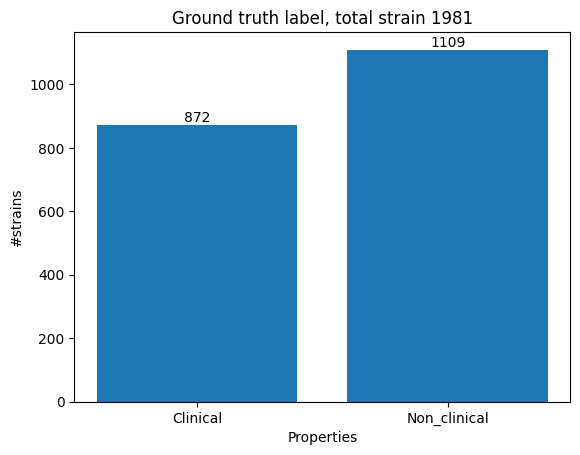

In [219]:
import matplotlib.pyplot as plt

# Data for the bars
values = [872, 1109]
labels = ['Clinical', 'Non_clinical']

# Create the bar plot
plt.bar(labels, values)

# Add labels to the bars
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Add a title and labels to the axes
plt.title('Ground truth label, total strain 1981')
plt.xlabel('Properties')
plt.ylabel('#strains')

# Show the plot
plt.show()
